<h1><center>Laboratorio 6: La desperación de Mr. Lepin 🐼</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Matías Rojas y Mauricio Araneda
- Auxiliar: Ignacio Meza D.
- Ayudante: Rodrigo Guerra

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Emilio Roa



:### **Link de repositorio de GitHub:** `https://github.com/ERoa98/MDS7202-Emilio-Roa`

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

# Temas a tratar

- Aplicar Pandas para obtener características de un DataFrame.
- Aplicar Pipelines.
- Aplicar Clusters sobre un conjunto de datos.

## Reglas:

- Fecha de entrega: 09/06/2021
- **Grupos de 2 personas**
- **Ausentes** deberán realizar la actividad solos. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.
- Código que no se pueda ejecutar, no será revisado.

### Objetivos principales del laboratorio

- Comprender y aprovechar las ventajas que nos ofrece la librería `pandas` con respecto a trabajar en Python 'puro'.
- Crear nuevas características para entrenar un modelo de clustering.
- Comprender como aplicar pipelines de Scikit-Learn para generar procesos más limpios.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `numpy`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre arreglos (*o tensores*).

## Descripción del laboratorio.

### Importamos librerias utiles 😸

In [ ]:
# Libreria Core del lab.
import numpy as np
import pandas as pd
import datetime
from IPython.display import HTML

# Libreria para plotear (En colab esta desactualizado plotly)
!pip install --upgrade plotly
import plotly.express as px
import plotly.graph_objects as go

# Librerias utiles
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.2 MB 5.1 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0


In [ ]:
# Si usted está utilizando Colabolatory le puede ser útil este código para cargar los archivos.
try:
    from google.colab import drive
    drive.mount("/content/drive")
    path = 'Dirección donde tiene los archivos en el Drive'
except: 
    print('Ignorando conexión drive-colab')

Ignorando conexión drive-colab


# Segmentación de Clientes en Tienda de Retail 🛍️

<p align="center">
  <img width=300 src="https://s1.eestatic.com/2018/04/14/social/la_jungla_-_social_299733421_73842361_854x640.jpg">
</p>

## 1.1 Cargar Dataset

Mr. Lepin, en una nueva reunión, le cuenta a ud y su equipo que los resultados derivados del análisis exploratorio de dato presentaron una gran utilidad para la empresa y que tiene un gran entusiasmo por continuar trabajando con ustedes.
Es por esto, que Mr. Lepin les pide que cargue y visualicen algunas de las filas que componen el Dataset.
A continuación un extracto de lo parlamentado en la reunión:

    - Usted: Es un gran logro para nuestro equipo que usted haya encontrado excelente el EDA. ¿Qué tiene en mente ahora?
    - Mr. Lepin: Resulta que hace algún tiempo, mientras tomaba un mojito en una reunión de gerentes en Panamá, oí a un *chato* acerca de **LRMFP**, que es un modelo que permite personificar a los clientes a través de la farbicación de distintos atributos que describen a los clientes. Lo encontré es-tu-pendo ñatito. 
    - Usted: Ehh bueno. Investigaremos acerca de este modelo y veremos lo que podemos hacer.

Por ende, su siguiente tarea es calcular **LRMFP** sobre cada cliente y luego hacer un análisis de las características generadas. Para esto, el área de ventas les entrega un nuevo archivo llamado `online_retail_II_cleaned.pickle`, quien posee los datos del DataFrame original limpios y listos para obtener las características solicitadas por Mr. Lepin.

In [ ]:
df_retail = pd.read_pickle("online_retail_II_cleaned.pickle")
df_retail = df_retail.astype(
    {
        "Invoice": "category",
        "StockCode": "category",
        "Description": "category",
        "Description": str,
        "Customer ID": "category",
        "Country": "category"
    }
)
df_retail.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## 1.2 Creación de nuevas Caracteristicas [2 Puntos] 

Como ya se les comento, Mr. Lepin esta interesado en obtener las características **LRMFP**, para esto les señala que estas características se construyen en base a las siguientes definiciones:

- **Length (L)**: Intervalo de tiempo, en días, entre la primera y la última visita del cliente. Mientras mas grande sea el valor, mas fiel es el cliente.
- **Recency (R)**: Indica la actualidad de la interacción de un cliente con la empresa, y da información sobre la tendencia a repetir la compra. Se define como: 
$$Recency(n)=\dfrac{1}{n} \sum^n_{i=1} date\_diff(t_{fecha final}, t_{m-i+1})$$

 Donde $date\_diff$ representa la diferencia en días entre la fecha de finalización del periodo de observación ($t_{fecha final}$), y la fecha de una visita del cliente cercana a $t_{fecha final}$, $t_{m-i+1}; t_{m}$ es la última visita del cliente; y n es el número de visitas recientes del cliente consideradas.

- **Monetary (M)**: El término "monetario" se refiere a la cantidad media de dinero gastada por cada visita del cliente durante el período de observación y refleja la contribución del cliente a los ingresos de la empresa.

- **Frequency (F)**: Se refiere al número total de visitas del cliente durante el periodo de observación. Cuanto mayor sea la frecuencia, mayor será la fidelidad del cliente. 

- **Periodicity (P)**: Representa si los clientes visitan las tiendas con regularidad.

$$Periodicity(n)=std(IVT_1, ..., IVT_n)$$

&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Donde $IVT$ denota el tiempo entre visitas y n representa el número de valores de tiempo entre visitas de un cliente.
 

$$IVT_i=date\_diff(t_{i+1},t)$$

En base a las definiciones señaladas, diseñe una función que permita obtener las características **LRMFP** recibiendo un DataFrame como entrada. Para esto, no estará permitido el uso de iteradores, utilice todas las herramientas que les ofrece `pandas` para realizar esto.

Una referencia que le puede ser útil es el [documento original](https://www.researchgate.net/publication/315979555_LRFMP_model_for_customer_segmentation_in_the_grocery_retail_industry_a_case_study) en donde se propone este método.

**Nota:** Para la $fechafinal$ utilice la fecha máxima del dataset más 1 día.

**Ejemplo de Resultado Esperado:**

| Customer ID | Length | Recency | Frequency | Monetary | Periodicity |
|------------:|-------:|--------:|----------:|---------:|------------:|
|   12346.0   |    294 |      67 |        46 |   -64.68 |        37.0 |
|   12347.0   |     37 |       3 |        71 |  1323.32 |         0.0 |
|   12349.0   |    327 |      43 |       107 |  2646.99 |        78.0 |
|   12352.0   |     16 |      11 |        18 |   343.80 |         0.0 |
|   12356.0   |     44 |      16 |        84 |  3562.25 |        12.0 |

**Respuesta:**

In [ ]:
df_retail

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
400942,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
400943,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
400944,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
400945,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [ ]:
def custom_features(dataframe_in):
    df=dataframe_in.copy()
    ### Length
    df_features=pd.DataFrame((df.groupby('Customer ID')['InvoiceDate'].max() - df.groupby('Customer ID')['InvoiceDate'].min()).dt.days)
    
    ### Recency
    t_fechafinal = df['InvoiceDate'].max() + datetime.timedelta(days = 1)
    df['date_diffs'] = (t_fechafinal - df.InvoiceDate).dt.days
    df_features['Recency']=(df[['Customer ID', 'date_diffs']].drop_duplicates().groupby('Customer ID')['date_diffs'].sum())/(df[['Customer ID', 'date_diffs']].drop_duplicates().groupby('Customer ID')['date_diffs'].count())
    
     ### Monetary
    df['Total']=df['Quantity']*df['Price']
    df_features['Monetary'] = (df.groupby(by=['Customer ID'])['Total'].sum())/(df[['Customer ID', 'InvoiceDate']].drop_duplicates().groupby(by=['Customer ID'])['InvoiceDate'].count())
    
    ### Frequency
    df_features['Frequency'] = df[['Customer ID', 'InvoiceDate']].drop_duplicates().groupby(by=['Customer ID'])['InvoiceDate'].count()
    
    ### Periodicity
    df_periodicity=df[['Customer ID', 'InvoiceDate']].drop_duplicates()
    df_periodicity['diffs']=(df_periodicity.sort_values(by='InvoiceDate', ascending=True).groupby('Customer ID')['InvoiceDate'].diff()).view(np.int64)
    df_features=df_features.merge(df_periodicity.groupby('Customer ID')['diffs'].std(), on='Customer ID').fillna(0)
    
    df_features.rename(columns={'InvoiceDate': 'Length', 'diffs': 'Periodicity'}, inplace=True)
    return df_features

In [ ]:
custom_features(df_retail).head()


,Length,Recency,Monetary,Frequency,Periodicity
Customer ID,,,,,
12346.0,196,308.285714,33.896364,11,2.781464e+18
12347.0,37,21.500000,661.660000,2,6.524171e+18
12348.0,0,74.000000,222.160000,1,0.000000e+00
12349.0,181,158.000000,890.380000,3,5.329654e+18
12351.0,0,11.000000,300.930000,1,0.000000e+00


**Resúesta de Pauta:**

## 1.3 Pipelines 👷

Finalmente *Don Mora* le pregunta si seria posible realizar un pipeline para realizar una segmentación de los clientes con los nuevos datos generados, a lo que usted responde que **sí** y propone la utilización de k-means para la segmentación.

A continuación siga los pasos requeridos para obtener la segmentación de clientes.

### 1.3.1 Estandarizar Caracteristicas [0.5 puntos]

Construya una clase llamada ``MinMax()`` utilizando ``BaseEstimator`` y ``TransformerMixin`` para realizar una transformación de cada una de las columnas de un DataFrame utilizando ``ColumnTransformer()`` más tarde (tome como referencia el siguiente [enlace](https://sklearn-template.readthedocs.io/en/latest/user_guide.html#transformer)).


 Para esto considere que Min-Max escaler queda dada por la ecuación:

$$MinMax = \dfrac{x-min(x)}{max(x) - min(x)}$$

Con esto buscamos que los valores que componen a las columnas se muevan en el rango de valores $[0, 1]$.

**Respuesta:**

In [ ]:
class MinMax(BaseEstimator, TransformerMixin):
    def fit(self, X):
      return self
    def transform(self, X):
        X2=X.copy()
        X2=(X2 - X2.min()) / (X2.max() - X2.min())
        return X2
      
    

### 1.3.2 `T-SNA` Pipeline [1.0 puntos]

Para comenzar introduciéndose en el uso de pipeline, decide probar realizando un pipeline enfocado en la reducción de dimensionalidad y así hacer no decepcionar a Mr. Lepin con la clusterización del modelo. 

Configure un pipeline utilizando el algoritmo `T-SNE` sobre los datos **LRMFP**, donde, para la realización del pipeline considera los siguientes pasos:

1. Como primer paso obtenga las características **LRMFP** desde el DataFrame ``df_retail_II_cleaned.pickle`` utilizando la función ``custom_features`` creada anteriormente, junto a ``FunctionTransformer()``. Considere esto como el primer paso de su pipeline.
2. En segundo lugar usando ``ColumnTransformer()`` aplique el MinxMax scaler creado por usted sobre todas las columnas generadas en el paso anterior. 
3. Finalmente, aplique un último paso donde obtiene las 2 componentes más relevantes utilizando el algoritmo T-sne de sckit-learn.

Tras aplicar las transformaciones sobre el dataset **LRMFP**, gráfique las componentes obtenidas en la reducción de dimensionalidad.

**Respuesta:**

In [ ]:
from sklearn.pipeline import Pipeline 
from sklearn.manifold import TSNE

pipe = Pipeline([('custom_features', FunctionTransformer(custom_features)),
                 ('MinMax', ColumnTransformer([("MinMax", MinMax(), ['Length','Recency','Monetary','Frequency','Periodicity'])])),
                 ('T-sne', TSNE())])

In [ ]:
tsne=pipe.fit_transform(df_retail)
df_tsne = pd.DataFrame(tsne, columns = ['PC1','PC2'])
px.scatter(df_tsne, x='PC1', y='PC2')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


### 1.3.3 Clustering

#### 1.3.3.1 Método del Codo [1 puntos]

Utilizando la clase creada para escalamiento, aplique el método del codo para visualizar cual es el número de clusters que mejor se ajustan a los datos. Realice esto utilizando el algoritmo K-means dentro de un pipeline para un $k \in [1,20]$, donde k representa el número de clusters del k-means. Para la realización de esta sección y la próxima (1.3.3.2), considere los mismos pasos utilizados para el t-sne, pero permutando el algoritmo de reducción de dimensionalidad por k-means.

A través del grafico obtenido, comente y justifique que valor de k escogería para realizar el k-means.

**Respuesta:**

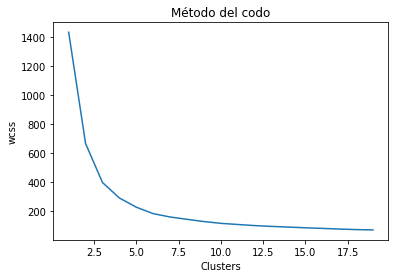

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss=[]
for i in range(1,20):
  pipe = Pipeline([('custom_features', FunctionTransformer(custom_features)),
                 ('MinMax', ColumnTransformer([("MinMax", MinMax(), ['Length','Recency','Monetary','Frequency','Periodicity'])])),
                 ('KMeans', KMeans(n_clusters=i, init='k-means++',random_state=42))])
  KM = pipe.fit(df_retail)
  wcss.append(KM['KMeans'].inertia_)

plt.plot(range(1,20), wcss)
plt.title('Método del codo')
plt.xlabel('Clusters')
plt.ylabel('wcss')
plt.show()

La idea básica dentro del algoritmo de clustering es la minimización de la varianza intra clusters y la maximización de la varianza inter clusters, es decir, se busca que cada observación esté cercana a las de su mismo grupo, pero entre los grupos exista una diferencia más clara o lejana.

Para determinar la cantidad óptima de clusters a utilizar se implementa el método del codo. El método del codo utiliza la distancia media de las observaciones en su centroide, fijándose principalmente en las distancias intra-clusters. Con esto, mientras menor sea la varianza intra-cluster, mayor será el número de clusters k. Este método busca el valor k que cumpla con que un incremento de k no mejore de manera sustancial la distancia media intra-cluster.

Observando la gráfica, el cambio de pendiente se tiene de forma más notoria entre los valores 6 y 5. A criterio del equipo de trabajo, se selecciona el valor de 6 clusters.

#### 1.3.3.2 Segmentación de Clientes con K-Means 🎁 [1 punto]

En base a la elección de k realizada en la sección anterior, utilice este valor escogido y entrene un modelo de K-means utilizando el mismo pipeline de scikit-learn utilizado anteriormente.

Una vez ajustado los datos, genere una tabla con los promedios (o medianas) para cada uno de los atributos, agrupando estos por el clúster que pertenecen. ¿Es posible observar agrupaciones coherentes?, ¿Qué tipo de clientes posee el retail?, Justifique su respuesta y no decepcione a Mr. Lepin.


**Respuesta:**

In [ ]:
pipe = Pipeline([('custom_features', FunctionTransformer(custom_features)),
                 ('MinMax', ColumnTransformer([("MinMax", MinMax(), ['Length','Recency','Monetary','Frequency','Periodicity'])])),
                 ('KMeans', KMeans(n_clusters=6, init='k-means++',random_state=42))])
kmean = pipe.fit_transform(df_retail)

In [ ]:
len(pipe['KMeans'].labels_)

4314

In [ ]:
df2 = custom_features(df_retail)
df2['Clusters'] = pipe['KMeans'].labels_
df2.head()

,Length,Recency,Monetary,Frequency,Periodicity,Clusters
Customer ID,,,,,,
12346.0,196,308.285714,33.896364,11,2.781464e+18,5
12347.0,37,21.500000,661.660000,2,6.524171e+18,4
12348.0,0,74.000000,222.160000,1,0.000000e+00,1
12349.0,181,158.000000,890.380000,3,5.329654e+18,0
12351.0,0,11.000000,300.930000,1,0.000000e+00,1


In [ ]:
df2.groupby(by=['Clusters']).mean()

,Length,Recency,Monetary,Frequency,Periodicity
Clusters,,,,,
0,229.908624,166.133572,370.888705,3.936345,4.954257e+18
1,0.323678,61.231022,357.297479,1.036524,5.922463e+15
2,89.521964,252.431346,371.888167,2.651163,5.907191e+18
3,0.357257,266.949052,337.379955,1.111643,5.024037e+15
4,65.215007,72.750410,378.051543,2.927850,5.740776e+18
5,326.044100,180.941053,428.533452,12.836710,3.058404e+18


Dentro de los grupos de clientes creados, es posible establecer ciertas diferencias en el comportamiento principal asociado a cada uno de ellos, por ejemplo, se tiene en los clusters 1 y 3 los valores más bajos de Lenght, es decir, son grupos de clientes menos fieles. En el lado contrario se encuentran los clusters 5 y 0 con unos valores más grandes de intervalo de tiempo, por ende, más fieles.

Analizando los valores de Recency, se tiene que el grupo 3, a pesar de ser un sector de clientes poco fieles, cuentan con una gran tendencia a repetir la compra. Por el contrario, los grupos 1 y 4 se ven como los grupos de clientes con menor tendencia a repetir compras.

Por parte de la variable Monetary, se tiene un grupo destacado por sobre el resto, el cual es el grupo 5. Este grupo se considera como el que contribuye con una mayor cantidad de dinero por visita. En cuanto a Frecuency, se ve una tendencia parecida a Monetary con el grupo 5, pues este destaca por sobre el resto con un valor de frecuencia de visitas bastante alto. Esto es bastante coherente con respecto a la fidelidad con la que cuentan los clientes en cuanto a las variables estudiadas.

Por último, en Periodicity cabe resaltar los bajos valores de los grupos 1 y 3, los cuales representaban los valores más bajos de fidelidad, concordando dentro de esta feature como los grupos con visitas menos regulares que el resto.

A modo de resumen, se podría decir que el grupo 5 serían los clientes favoritos para Mr. Lepin, estos son los más fieles y quienes más contribuyen monetariamente a la empresa (Los grupos 0 y 2 sería los grupos más cercanos a este considerando las características mencionadas). Por el contrario, los grupos de clientes menos fieles y regulares son los grupos 1 y 3, por lo que Mr. Lepin debería preocuparse más de integrar con una propuesta atractiva a este sector de clientes.

**Respuesta Esperada:**

|         | Length  | Recency   | Frequency | Monetary | Periodicity |       |
|---------|---------|-----------|----------|-------------|-------|-------|
| Cluster |         |           |          |             |       |       |
|    0    |   258.8 |      45.2 |     76.1 |      1107.7 | 107.6 |   449 |
|    1    |    76.1 |     217.6 |     45.5 |       791.7 |  14.1 |   466 |
|    2    |   368.5 |       4.8 |   2715.0 |    226621.6 |   4.2 |     4 |
|    3    |    85.3 |      45.7 |     65.8 |      1047.0 |  10.5 |   987 |
|    4    |   347.2 |      15.9 |   1658.0 |     35829.3 |   8.0 |    25 |
|    5    |   298.0 |      29.8 |    183.8 |      3639.9 |  32.0 |  1188 |

#### 1.3.3.3 Plot de K-Means 📈 [0.5 puntos]



Por último, Mr. Lepin, impaciente de no entender lo que usted intenta explicarle, le solicita que por favor muestre algún resultado "visual" de los grupos encontrados.

Para esto, grafique nuevamente las características encontradas usando `T-SNE` (no calcule de nuevo, simplemente utilice las proyecciones encontradas) y agregue las labels calculadas con kmeans como el argumento `color`.   

Comente: ¿Se separan bien los distintos clusters en la visualización?


**Respuesta:**

In [ ]:
df_tsne['Cluster'] = pipe['KMeans'].labels_

In [ ]:
px.scatter(df_tsne, x='PC1', y='PC2', color=df_tsne['Cluster'])

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana y que **los días de atraso no se pueden utilizar para entregas de lab** solo para tareas. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://i.pinimg.com/originals/65/ae/27/65ae270df87c3c4adcea997e48f60852.gif "bruno")


<br>
<center>
<img src="https://i.kym-cdn.com/photos/images/original/001/194/195/b18.png" width=100 height=50 />
</center>
<br>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>